In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

In [4]:
def read_cred():
    f = open("../../../cred.txt", "r")
    cred = f.read()
    f.close()
    return cred

In [5]:
def get_OI(url,start,end,interval='PT1M',tag='xx',auth='xx',hS='00',hF='23'):
	url_all =url+'data-reference='+tag+'&aggregation=TIME'+'&aggregation-function=MEAN'+"&from="+start+"T"+hS+"%3A00%3A00.000Z&to="+end+"T"+hF+"%3A59%3A59.000Z&aggregation-period="+interval
	d_data = pd.read_json(url_all,storage_options={ 'Authorization': 'basic '+auth})
	# print(d_data['values'][0])
	arr = np.asarray(np.asarray(d_data['values'])[0])
	return d_data['values'][0]

In [6]:
urlBase = 'https://oianalytics-100.optimistik.fr/api/oianalytics/time-values/query?'
credentials = read_cred()

In [7]:
def get_data(tags):
    liste = list(range(0))
    for tag in tags:
        data = get_OI(urlBase,'2021-07-01','2022-01-31','PT20M',tag,credentials,'00','23')
        df = pd.DataFrame(data)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df = df.rename(columns={'value':tag})
        liste.append(df)
    return liste

In [8]:
def merge_data(liste):
    df = reduce(lambda left,right : pd.merge(left, right,left_index=True,right_index=True,how='outer'),liste)
    return df

In [103]:
tags = ['E-T15223','E-T18223','3B-T99994','E-FC16325','E-FCS14325','E-FCS12085','E-FS31053','E-FC33005','E-FQ41504','E-QUR-E2']
#tags = ['E-T15223','E-T18223','E-FCS14325','E-FC16325','E-FCS12085','E-LS18603','E-LC18604','E-LS15603','E-LC15604','E-FS31053','E-PD15010','E-PD18010','3B-T99994','E-QUR-E2','ROC_E2_Prod_MMP_brut','E-FQ41504','E-TC18202','E-TC15202']
df_list = get_data(tags)
data = merge_data(df_list)
result = data.copy()
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504,E-QUR-E2
count,15477.000000,15477.000000,15431.000000,15477.000000,15477.000000,15477.000000,15477.000000,15477.000000,15477.000000,1.547700e+04
mean,389.804087,382.536342,14.361513,8046.045421,4256.441424,45413.754243,9822.273131,122824.445097,15906.140188,6.235928e+02
std,22.538717,20.687768,8.508218,2469.877058,1184.444237,12940.814955,2821.369975,20955.877545,4956.890090,3.302491e+05
min,268.276000,247.917750,-3.491465,-0.075176,14.089720,3.949767,12.239705,0.263694,-26.876130,-3.534675e+07
25%,388.287400,381.918900,6.902344,7447.013000,3818.675500,43995.870000,9986.649000,117993.800000,14878.360000,5.161899e+02
50%,396.603900,387.284200,14.367705,9345.362500,4686.648500,51500.850000,10497.800000,131479.100000,18523.380000,5.207433e+02
75%,400.826550,392.212750,20.907160,9590.683500,4784.712500,52499.325000,11020.430000,133498.600000,19001.255000,5.257549e+02
max,423.423450,414.827000,37.633960,10076.175000,7537.602500,52554.240000,12871.715000,136183.400000,22686.530000,1.995554e+07


## Filtre

In [12]:
def filtering(df):
    df = df[(df['E-QUR-E2']>500) & (df['E-QUR-E2']<600)]
    df = df[df['E-T15223']>390]
    df = df[df['E-FC16325']>9000]
    df = df[df['E-FCS12085']>52400]
    return df

In [104]:
result = filtering(result)
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504,E-QUR-E2
count,6953.000000,6953.000000,6907.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000
mean,399.380534,388.508463,15.745557,9596.387108,4899.641212,52499.918337,10235.964997,133383.877613,18994.634562,521.577561
std,4.269080,3.943194,8.114820,53.372143,251.166420,13.785763,424.643594,1975.380893,203.855890,6.073370
min,390.021700,379.029900,-1.309197,9046.789500,4201.492000,52400.735000,9118.181000,124975.250000,17887.955000,500.148650
25%,396.509350,385.786650,8.430613,9570.465500,4728.212000,52491.030000,9907.899000,132476.350000,18870.250000,517.755300
50%,399.255700,388.205850,16.624010,9593.218000,4766.931500,52500.035000,10245.115000,133029.850000,19012.520000,521.281450
75%,401.883350,391.549500,22.018265,9619.180500,5183.257500,52509.060000,10551.755000,135035.850000,19140.865000,524.673750
max,414.160700,402.746700,37.123310,10076.175000,5714.991500,52554.240000,11204.220000,136183.400000,19984.880000,558.168200


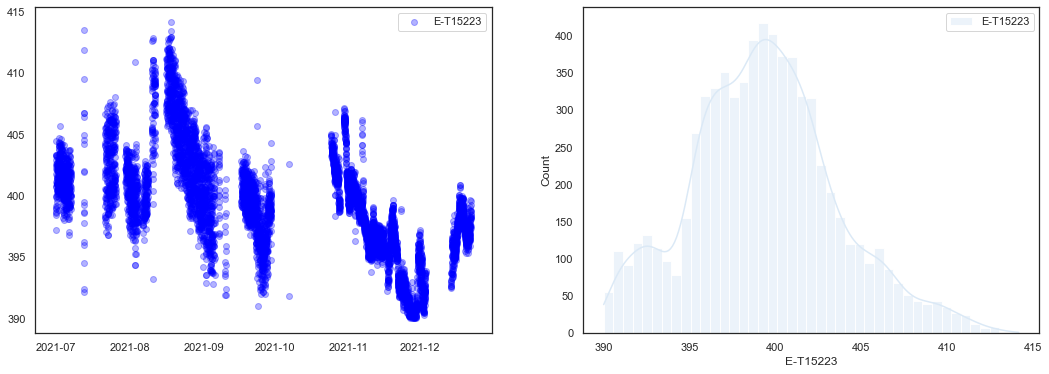

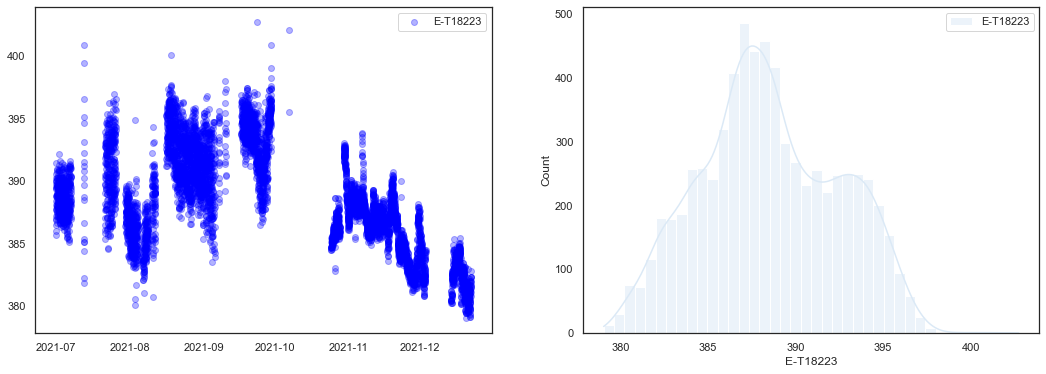

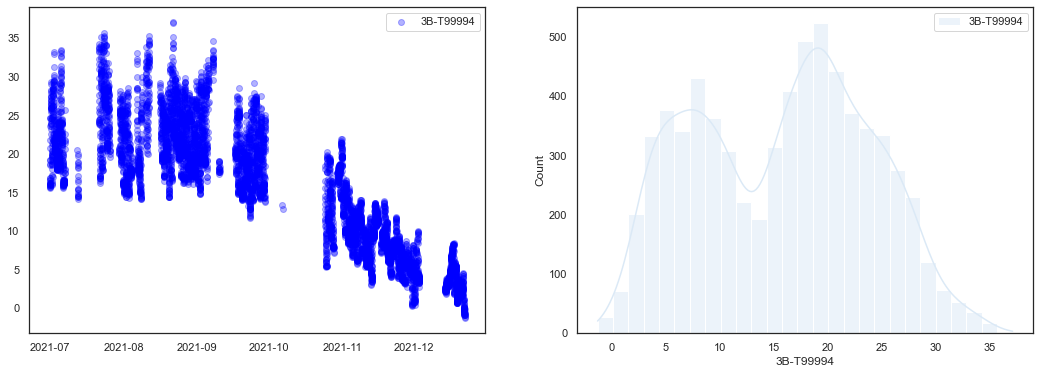

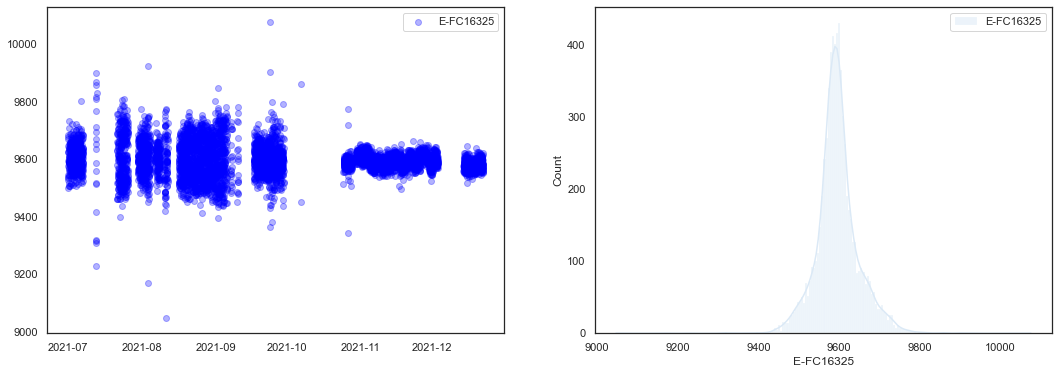

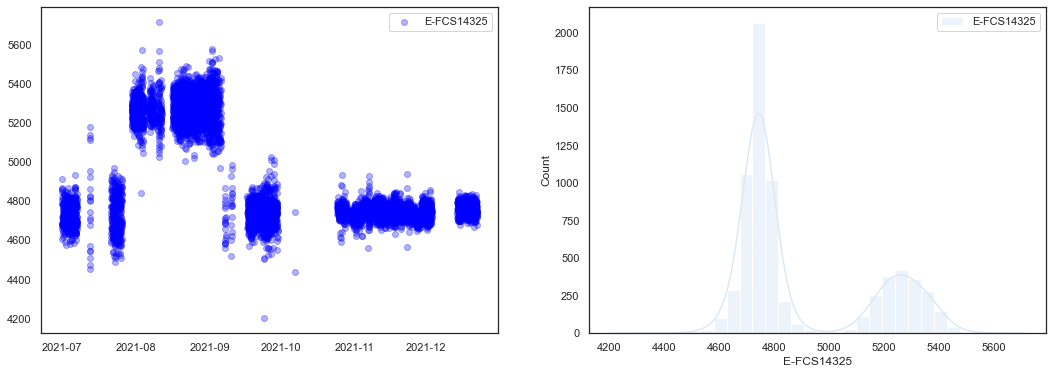

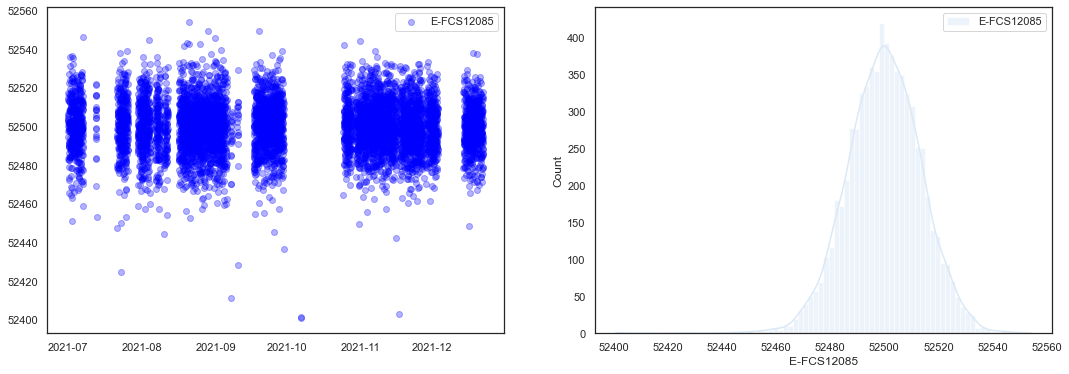

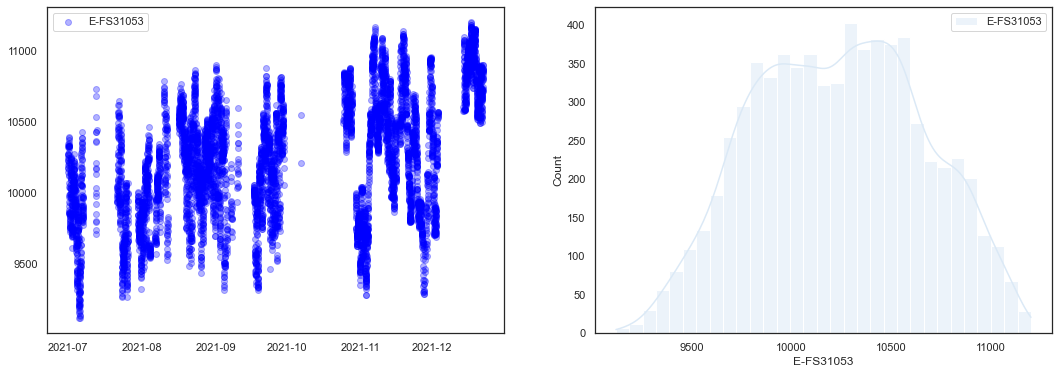

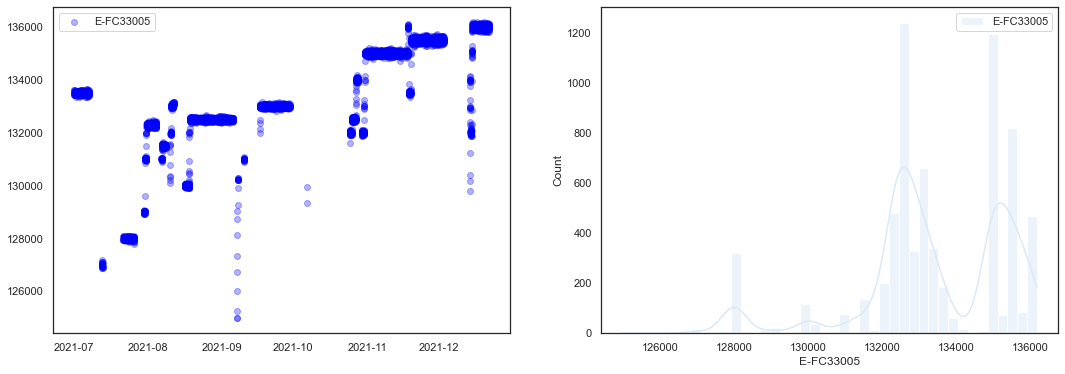

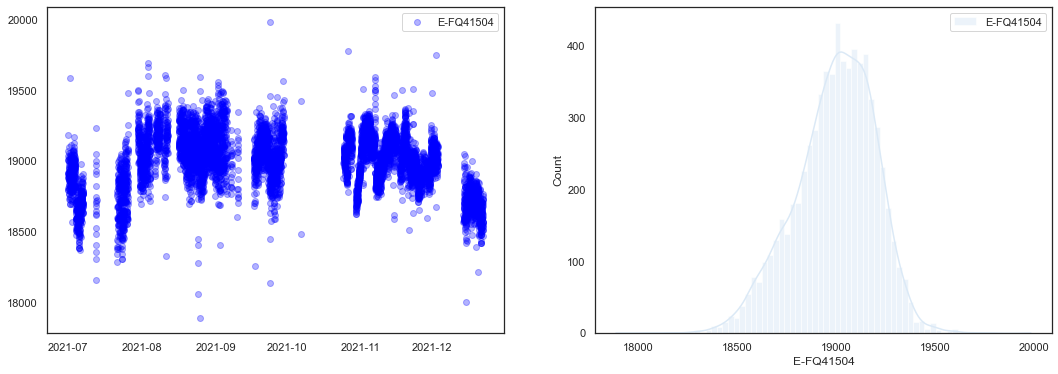

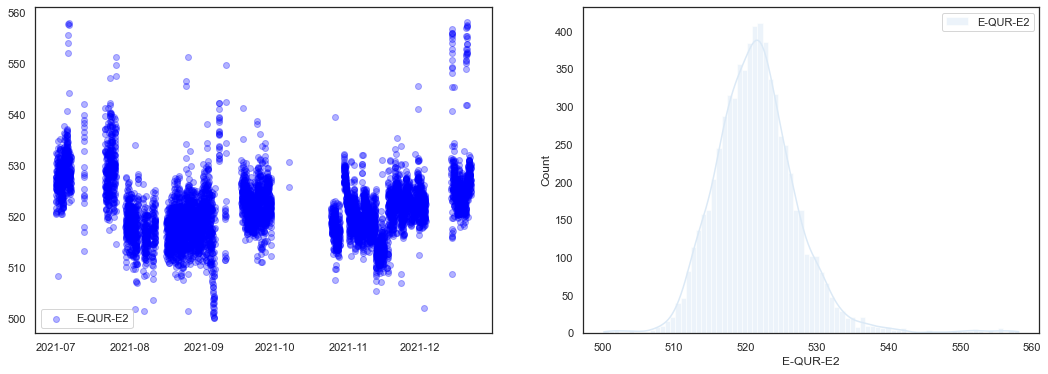

In [105]:
for tag in tags:
    plt.figure(figsize=(18,6))
# plt.plot(result[tags[0]],label=tags[0])
    plt.subplot(121)
    plt.scatter(result.index ,result[tag],label=tag, c='b', alpha=0.3)
    plt.legend()
    plt.subplot(122)
    sns.histplot(result[tag],label=tag,kde=True,common_norm=True)
    plt.legend()

In [22]:
def get_perf(row):
    crit = 'E-QUR-E2'
    if row['E-QUR-E2'] > 540:
        ret=10
    elif row['E-QUR-E2']>535:
        ret=9
    elif row['E-QUR-E2']>530:
        ret=8
    elif row['E-QUR-E2']>525:
        ret=7
    elif row['E-QUR-E2']>520:
        ret=6
    elif row['E-QUR-E2']>515:
        ret=5
    elif row['E-QUR-E2']>510:
        ret=4
    elif row['E-QUR-E2']>505:
        ret=3
    elif row['E-QUR-E2']>500:
        ret=2
    elif row['E-QUR-E2']>495:
        ret=1
    else:
        ret =0
    return ret   

In [106]:
result['perf'] = result.apply(get_perf,axis=1)
result = result.drop('E-QUR-E2',axis=1)
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504,perf
count,6953.000000,6953.000000,6907.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000
mean,399.380534,388.508463,15.745557,9596.387108,4899.641212,52499.918337,10235.964997,133383.877613,18994.634562,5.802963
std,4.269080,3.943194,8.114820,53.372143,251.166420,13.785763,424.643594,1975.380893,203.855890,1.184022
min,390.021700,379.029900,-1.309197,9046.789500,4201.492000,52400.735000,9118.181000,124975.250000,17887.955000,2.000000
25%,396.509350,385.786650,8.430613,9570.465500,4728.212000,52491.030000,9907.899000,132476.350000,18870.250000,5.000000
50%,399.255700,388.205850,16.624010,9593.218000,4766.931500,52500.035000,10245.115000,133029.850000,19012.520000,6.000000
75%,401.883350,391.549500,22.018265,9619.180500,5183.257500,52509.060000,10551.755000,135035.850000,19140.865000,6.000000
max,414.160700,402.746700,37.123310,10076.175000,5714.991500,52554.240000,11204.220000,136183.400000,19984.880000,10.000000


<AxesSubplot:ylabel='perf'>

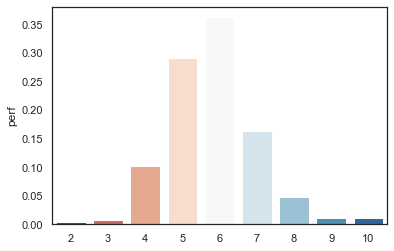

In [146]:
freq = (result.perf.value_counts() / result.shape[0])
df = pd.DataFrame(freq).sort_index()
sns.barplot(data=df, x=df.index,y='perf',palette='RdBu')


<AxesSubplot:xlabel='E-FC16325', ylabel='Count'>

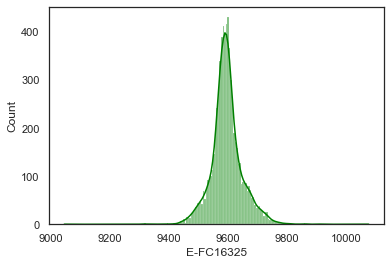

In [110]:
sns.color_palette("tab10")
sns.color_palette("rocket", as_cmap=True)
couleur = ['b','g','r','y','g']
sns.histplot(result['E-FC16325'],kde=True , color='g')

<AxesSubplot:>

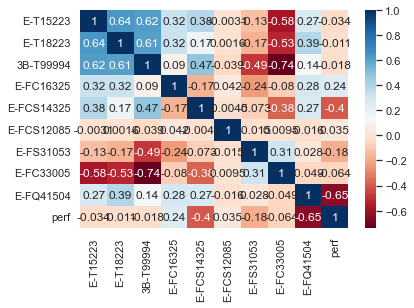

In [144]:
sns.color_palette("tab10")
sns.heatmap(result.corr(),annot=True, cmap='RdBu')

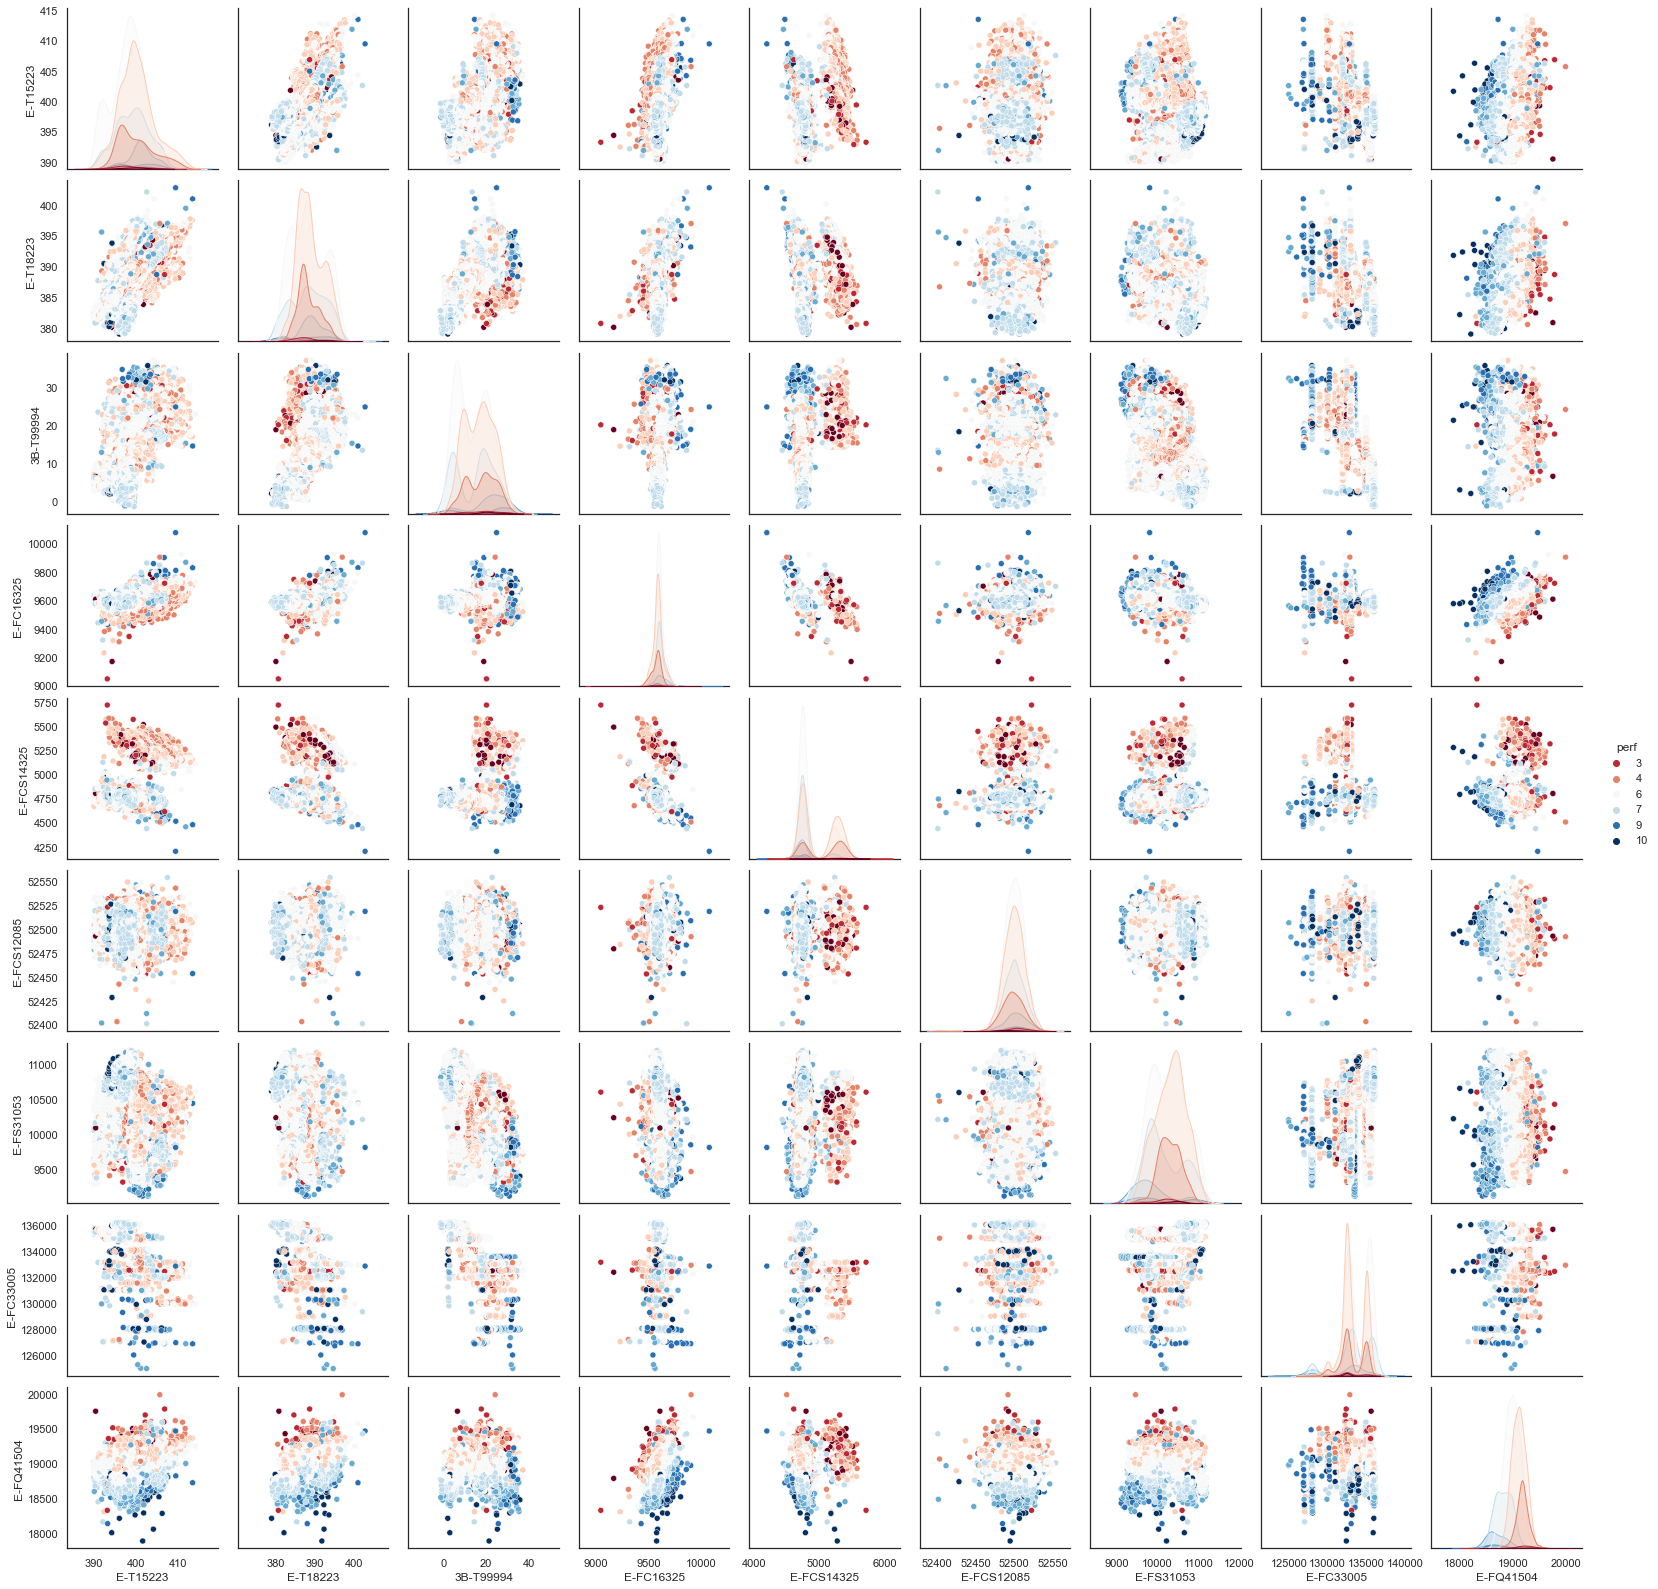

In [112]:
# sns.set_theme(style="ticks")
sns.set_theme(style='white',palette='Blues')
sns.color_palette("tab10")
sns.pairplot(data=result, hue='perf',palette='RdBu') 

# Machine Learning

### On sépare Trainset et Testset
et on vérifie que les deux jeux de données sont bien équilibrés

<AxesSubplot:ylabel='perf'>

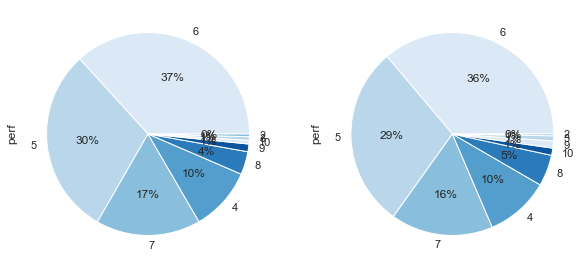

In [170]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(result,test_size=0.8,random_state=0)
plt.figure(figsize=(10,7))
plt.subplot(121)
trainset['perf'].value_counts().plot.pie(autopct='%.0f%%')
plt.subplot(122)
testset['perf'].value_counts().plot.pie(autopct='%.0f%%')

## Preprocessing

In [171]:
def encodage(df):
    return df

In [172]:
def imputation(df):
    df =  df.dropna(axis=0)
    return df

In [173]:
def feature_engineering(df):
    return df

In [174]:
def preprocessing(df):
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)

    X = df.drop('perf',axis=1)
    y = df['perf']

    print(y.value_counts())
    return X,y 

In [175]:
X_train, y_train = preprocessing(trainset)
X_train

6     511
5     409
7     232
4     141
8      51
9      17
10      8
3       8
2       6
Name: perf, dtype: int64


,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504
timestamp,,,,,,,,,
2021-11-19 18:00:00+00:00,397.28230,388.94990,7.131322,9583.0990,4711.2510,52507.425,10588.5750,135402.75,19122.115
2021-09-24 03:00:00+00:00,398.43905,393.24615,14.351210,9658.4875,4669.0450,52501.975,10079.7100,132957.75,18882.685
2021-11-01 04:20:00+00:00,399.15280,387.05325,12.491270,9612.6410,4752.6810,52493.330,10002.8070,134996.10,19051.505
2021-12-19 04:00:00+00:00,399.23540,381.92730,1.654178,9558.9535,4708.4205,52484.555,10825.3750,136082.15,18857.385
2021-11-21 18:00:00+00:00,392.79680,384.71240,7.867254,9590.4650,4749.0055,52492.470,9818.4135,135433.85,18874.705
...,...,...,...,...,...,...,...,...,...
2021-11-10 13:20:00+00:00,395.82725,386.69920,9.874218,9563.7925,4685.3165,52510.530,10646.9200,134980.75,18951.660
2021-09-21 17:20:00+00:00,400.12975,394.53650,20.215505,9634.1000,4695.1775,52489.170,10248.3900,132926.15,19226.135
2021-08-19 10:20:00+00:00,406.43155,392.54285,23.126740,9580.3190,5299.9100,52469.130,10166.0700,132557.00,19090.000


<AxesSubplot:ylabel='perf'>

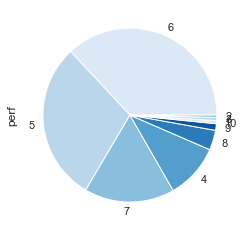

In [176]:
y_train.value_counts().plot.pie()

In [177]:
X_test, y_test = preprocessing(trainset)

6     511
5     409
7     232
4     141
8      51
9      17
10      8
3       8
2       6
Name: perf, dtype: int64


## Model de base et procédure d'évaluation

In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# model = make_pipeline( PolynomialFeatures(2),SelectKBest(f_classif,k=10), RandomForestClassifier(random_state=0))

# model = make_pipeline( SelectKBest(f_classif,k=4), RandomForestClassifier(random_state=0))
model_1 = DecisionTreeClassifier(random_state=0)

In [179]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [180]:
def evaluation(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    N, train_score, val_score = learning_curve(model,X_train,y_train,cv=4,train_sizes=np.linspace(0.1,1,10),scoring='f1')
    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),c='b')
    plt.plot(N,val_score.mean(axis=1),c='y')

[[  6   0   0   0   0   0   0   0   0]
 [  0   8   0   0   0   0   0   0   0]
 [  0   0 141   0   0   0   0   0   0]
 [  0   0   0 409   0   0   0   0   0]
 [  0   0   0   0 511   0   0   0   0]
 [  0   0   0   0   0 232   0   0   0]
 [  0   0   0   0   0   0  51   0   0]
 [  0   0   0   0   0   0   0  17   0]
 [  0   0   0   0   0   0   0   0   8]]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00       141
           5       1.00      1.00      1.00       409
           6       1.00      1.00      1.00       511
           7       1.00      1.00      1.00       232
           8       1.00      1.00      1.00        51
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00         8

    accuracy                           1.00      1383
   macro avg       1.00      1.00      1.00      138

/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, in fbet

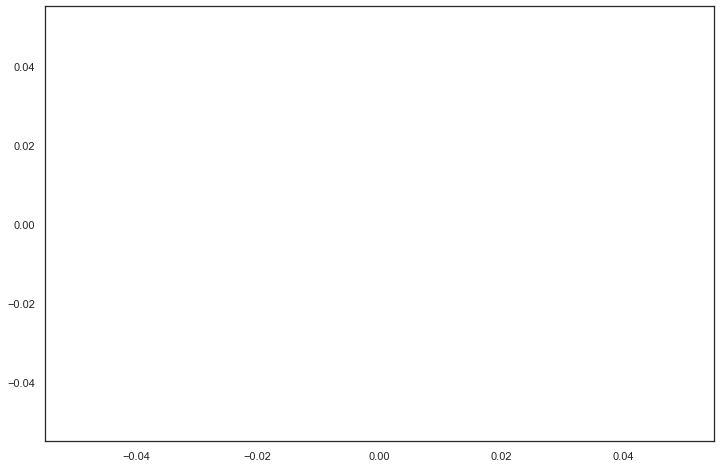

In [181]:
evaluation(model_1)